[*********************100%***********************]  1 of 1 completed
C:\Users\lenovo\AppData\Local\Temp\ipykernel_19196\813790471.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  wealth_history[i, t] = agent.real_wealth


Best wealth ratio: 5.81
Average wealth ratio: 1.99
Worst wealth ratio: 0.01


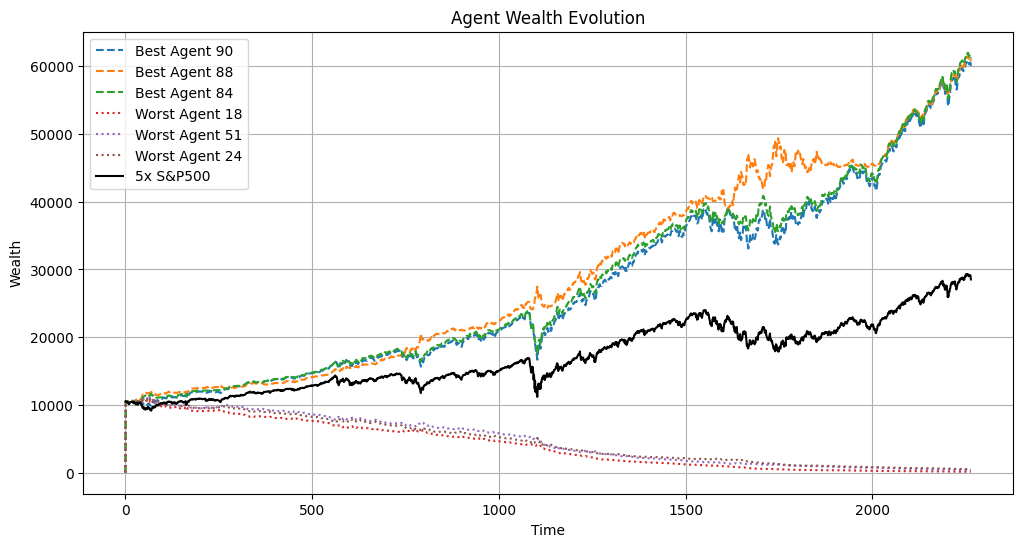

In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random

class Strategy:
    def __init__(self, m, initial_price):
        self.m = m
        self.num_states = 2 ** m
        self.decisions = self._generate_valid_strategy()
        self.virtual_wealth = 5 * initial_price
        self.virtual_position = 0
        
    def _generate_valid_strategy(self):
        
        while True:
            decisions = np.random.choice([-1, 0, 1], size=self.num_states)
            if 1 in decisions and -1 in decisions:
                return decisions
    
    def get_decision(self, state):
        return self.decisions[state]

class Agent:
    def __init__(self, num_strategies, m, initial_price):
        self.strategies = [Strategy(m, initial_price) for _ in range(num_strategies)]
        self.real_wealth = 5 * initial_price
        self.real_position = 0
        self.current_strategy = random.randint(0, num_strategies-1)
    
    def choose_best_strategy(self):
        
        wealths = [s.virtual_wealth for s in self.strategies]
        self.current_strategy = np.argmax(wealths)
        return self.current_strategy

class WealthGame:
    def __init__(self, n_agents=101, m=3, s=2, beta=0.5):
        self.n_agents = n_agents
        self.m = m
        self.s = s
        self.beta = beta
        self.current_state = 0
        
    def download_data(self):
        start_date = '2015-11-01'
        end_date = '2024-11-01'
        sp500 = yf.download('^GSPC', start=start_date, end=end_date)
        self.prices = sp500['Close'].values
        self.transaction_prices = self._calculate_transaction_prices()
        
    def _calculate_transaction_prices(self):
   
        p_t = np.zeros_like(self.prices)
        p_t[0] = self.prices[0]
        for t in range(len(self.prices)-1):
            p_t[t+1] = self.prices[t] + self.beta * (self.prices[t+1] - self.prices[t])
        return p_t
    
    def update_state(self, price_change):

        bit = 1 if price_change > 0 else 0
        self.current_state = (2 * self.current_state + bit) % (2 ** self.m)
        return self.current_state
    
    def run_simulation(self):

        self.download_data()
        self.agents = [Agent(self.s, self.m, self.prices[0]) for _ in range(self.n_agents)]
        wealth_history = np.zeros((self.n_agents, len(self.prices)))
        
        for t in range(1, len(self.prices)):
            price_change = self.prices[t] - self.prices[t-1]
            current_state = self.update_state(price_change)
            
            for i, agent in enumerate(self.agents):

                strategy_idx = agent.choose_best_strategy()
                strategy = agent.strategies[strategy_idx]
                
                decision = strategy.get_decision(current_state)
                
                for s in agent.strategies:
                    new_position = s.virtual_position + s.get_decision(current_state)
                    position_limit = s.virtual_wealth / self.prices[t]
                    s.virtual_position = np.clip(new_position, -position_limit, position_limit)
                
                    s.virtual_wealth += s.virtual_position * (
                        self.transaction_prices[t] - self.transaction_prices[t-1])
                
                new_position = agent.real_position + decision
                position_limit = agent.real_wealth / self.prices[t]
                agent.real_position = np.clip(new_position, -position_limit, position_limit)
                
                agent.real_wealth += agent.real_position * (
                    self.transaction_prices[t] - self.transaction_prices[t-1])
                
                wealth_history[i, t] = agent.real_wealth
        
        return wealth_history

    def analyze_results(self, wealth_history):
        
        initial_wealth = 5 * self.prices[0]
        final_wealth_ratio = wealth_history[:, -1] / initial_wealth
        
        best_agents = np.argsort(final_wealth_ratio)[-3:]
        worst_agents = np.argsort(final_wealth_ratio)[:3]
        
        print(f"Best wealth ratio: {final_wealth_ratio[best_agents[-1]]:.2f}")
        print(f"Average wealth ratio: {np.mean(final_wealth_ratio):.2f}")
        print(f"Worst wealth ratio: {final_wealth_ratio[worst_agents[0]]:.2f}")
        
        plt.figure(figsize=(12, 6))
        
        for agent_idx in best_agents:
            plt.plot(wealth_history[agent_idx], 
                    label=f'Best Agent {agent_idx+1}', 
                    linestyle='--')
            
        for agent_idx in worst_agents:
            plt.plot(wealth_history[agent_idx], 
                    label=f'Worst Agent {agent_idx+1}', 
                    linestyle=':')

        plt.plot(5 * self.prices, label='5x S&P500', color='black')
        
        plt.xlabel('Time')
        plt.ylabel('Wealth')
        plt.title('Agent Wealth Evolution')
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    np.random.seed(42)
    random.seed(42)
    
    game = WealthGame()
    wealth_history = game.run_simulation()
    game.analyze_results(wealth_history)

if __name__ == "__main__":
    main()

(12) 

Best wealth ratio: 5.81

Average wealth ratio: 1.99

Worst wealth ratio: 0.01

(13) 

From the chart, we can observe:
Best agents (84, 88, 90) show continuously rising wealth curves, reaching approximately 60000.
Worst agents (18, 24, 51) show continuously declining wealth curves, approaching 0.
The 5x S&P500 index (black line) stays in the middle, reaching approximately 30000.

(14) Strategy and Agent Analysis:

Winner Characteristics:

Successful agents accurately capture market trends, maintaining larger long positions during upward trends.Best agents' strategies demonstrate good risk management capabilities, adjusting positions timely during market volatility. Their strategies perform consistently in different market environments, indicating strong adaptability.

Loser Characteristics:

Worst agents often make decisions contrary to market trends.They might over-trade, frequently changing positions leading to high transaction costs.Poor risk management, suffering excessive losses in unfavorable market conditions.

Strategy Adaptability:

When market trends are clear (like the upward trend in the chart), trend-following strategies perform best.During high volatility periods (oscillating areas in the chart), strategies with good risk control have advantages.Successful agents can flexibly switch strategies in different market environments.